# Setup

In colab:
1. Go to "Runtime" -> "Change runtime type" -> Select "T4 GPU"
2. Install TerraTorch

In [ ]:
# Install required packages in Colab
!pip install git+https://github.com/IBM/terratorch.git
!pip install rioxarray matplotlib
!wget https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/notebooks/plotting_utils.py

In [4]:
import os
import torch
import rioxarray as rxr
import matplotlib.pyplot as plt
from terratorch.registry import FULL_MODEL_REGISTRY
import sys
sys.path.append('../')
from src.utils import plot_s2, plot_modality

# Select device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

In [5]:
# Build model that generates S-2 L2A (via tokenizer), S-1 GRD, S-1 RTC, DEM, LULC, and NDVI based on raw S-2 L2A input.
# Please note that each output modality requires its own tokenizer which increases the memory requirements
model = FULL_MODEL_REGISTRY.build(
    'terramind_v1_base_generate',
    modalities=['S2L2A'],  # Define the input
    output_modalities=['S1GRD', 'DEM', 'LULC'],  # Define the output from S2L2A, S1GRD, S1RTC, DEM, LULC, and NDVI
    pretrained=True,
    standardize=True,  # If standardize=True, you don't need to do the standardization yourself.
    # offset={'S2L2A': 1000}  # Optional offset in your data. The offset is also applied to the generation. 
)

_ = model.to(device)

# If you need the standardization values, see
from terratorch.models.backbones.terramind.model.terramind_register import v1_pretraining_mean, v1_pretraining_std

In [8]:
# Save the model
torch.save(model, '../models/terramind_v1_base_generate.pth')

In [9]:
if os.path.exists('../examples'):
  # Load local S-2 L2A example paths
  examples = [
      '../examples/S2L2A/38D_378R_2_3.tif',
      '../examples/S2L2A/282D_485L_3_3.tif',
      '../examples/S2L2A/433D_629L_3_1.tif',
      '../examples/S2L2A/637U_59R_1_3.tif',
      '../examples/S2L2A/609U_541L_3_0.tif',
  ]
else:
  # Download examples to Colab
  !wget -q https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/examples/S2L2A/38D_378R_2_3.tif
  !wget -q https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/examples/S2L2A/282D_485L_3_3.tif
  !wget -q https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/examples/S2L2A/433D_629L_3_1.tif
  !wget -q https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/examples/S2L2A/637U_59R_1_3.tif
  !wget -q https://raw.githubusercontent.com/IBM/terramind/refs/heads/main/examples/S2L2A/541L_3_0.tif
  examples = [
      '38D_378R_2_3.tif',
      '282D_485L_3_3.tif',
      '433D_629L_3_1.tif',
      '637U_59R_1_3.tif',
      '609U_541L_3_0.tif',
  ]

In [10]:
example_id = 1  # Select id between 0 and 4
# Load an S-2 L2A example
data = rxr.open_rasterio(examples[example_id])
# Convert to shape [B, C, 224, 224]
data = torch.Tensor(data.values, device='cpu').unsqueeze(0)

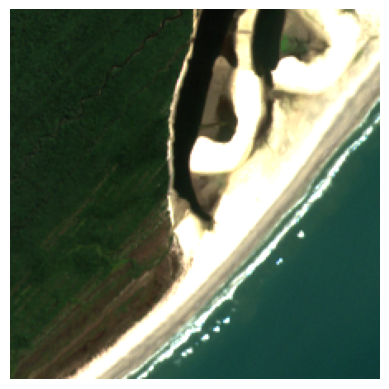

In [11]:
# Visualize S-2 L2A input as RGB
plot_s2(data)

In [12]:
# Run model with diffusion steps
input = data.to(device)
with torch.no_grad():
  generated = model(input, verbose=True, timesteps=10)

100%|██████████| 10/10 [00:00<00:00, 20.53it/s]


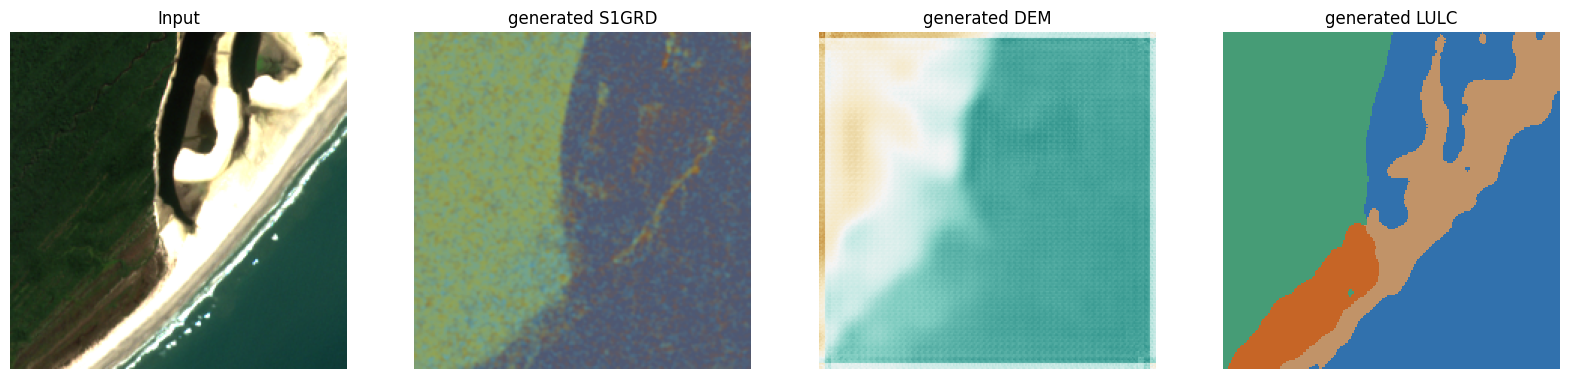

In [13]:
# Plot generations
n_plots = len(generated) + 1
fig, ax = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))

plot_s2(input, ax=ax[0])
ax[0].set_title('Input')

for i, (mod, value) in enumerate(generated.items()):
    plot_modality(mod, value, ax=ax[i + 1])

    ax[i+1].set_title('generated ' + mod)
    
plt.show()